## Import data

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
COLORS = {'green': '#00afa5', 'blue': '#005ae8', 'orange': '#f17900', 'red': '#ae0060', 'gray': '#c5d5db'}
dataset = pd.read_excel('ACTION_patients_overlap_only.xlsx')
dataset['P_NUMBER'] = dataset['P_NUMBER'].fillna(method='ffill')
overlap_array = np.array(dataset['TOTAL_OVERLAP (cc)']).reshape(len(dataset['P_NUMBER'].unique()), 6)
import re
prescription_doses = []
for entry in dataset['PRESCRIPTION_DOSE']:
    if type(entry) == str:
        match = re.search(r'(\d+(?:\.\d+)?)\s*x\s*(\d+(?:\.\d+)?)', entry)
        if match:
            result = float(match.group(1)) * float(match.group(2))
            prescription_doses.append(result)


## Prior calculation
Here we take the patient data to compute the prior distribution used to model the uncertainty in the overlap volumes.

In [75]:
from adaptive_fractionation_overlap.helper_functions import hyperparam_fit
alpha, beta = hyperparam_fit(overlap_array)
observed_stds = overlap_array.std(axis=1)
observed_means = overlap_array.mean(axis=1)

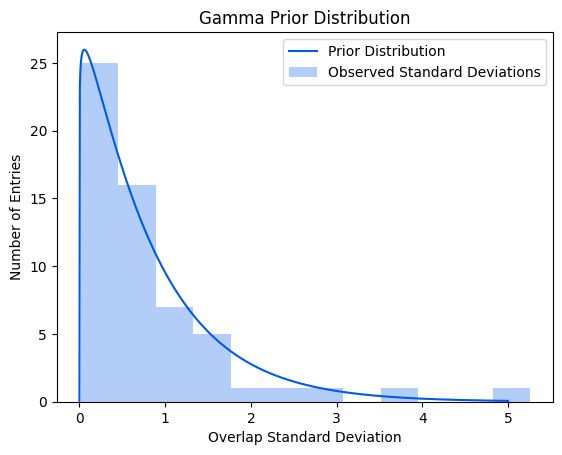

In [76]:
# Calculate the histogram (to get bin width and counts)
counts, bins = np.histogram(observed_stds, bins=12)
bin_width = bins[1] - bins[0]
n_entries = len(observed_stds)

# Rescale the PDF
x = np.linspace(0, 5, 1000)
y = gamma.pdf(x, a=alpha, scale=beta)
y_scaled = y * n_entries * bin_width

plt.plot(x, y_scaled, label='Prior Distribution', color=COLORS['blue'])
plt.xlabel('Overlap Standard Deviation')
plt.ylabel('Number of Entries')
plt.title('Gamma Prior Distribution')
plt.hist(observed_stds, bins=12, density=False, alpha=0.3, label='Observed Standard Deviations', color=COLORS['blue'])
plt.legend()
plt.show()

## Single Patient Illustrations

In the paper we take a closer look at patients 3 and 49. Here we generate the figures used in the paper.

In [77]:
import adaptive_fractionation_overlap as afx
overlaps_49 = overlap_array[48]
overlaps_3 = overlap_array[2]

## Patient 3

### First Fraction

In [78]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 1, volumes = overlaps_3[:2],accumulated_dose =  0, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 6.6, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

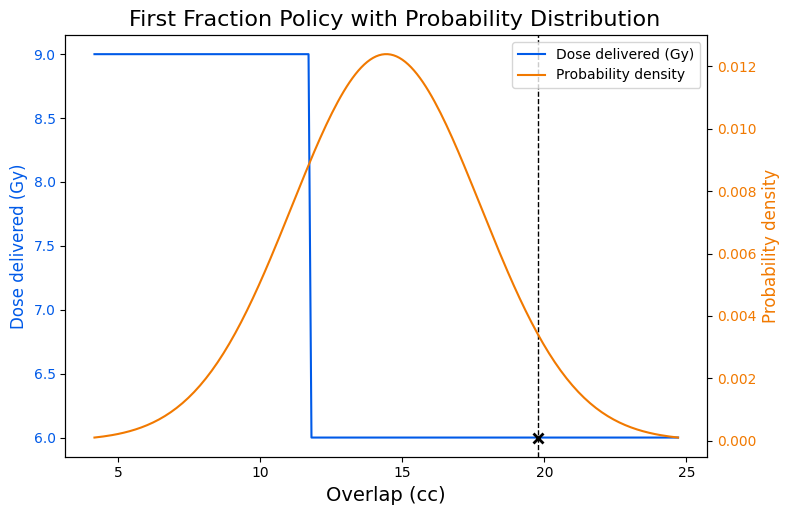

In [79]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, policies_overlap, color=COLORS['blue'], label='Dose delivered (Gy)')
ax1.set_xlabel('Overlap (cc)',fontsize = 14)
ax1.set_ylabel('Dose delivered (Gy)', color=COLORS['blue'],fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at 19.79
ax1.axvline(x=19.79, color='k', linestyle='--', linewidth=1)

# Add black cross at (19.79, 6)
ax1.plot(19.79, 6, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
fig.suptitle('First Fraction Policy with Probability Distribution', fontsize=16, y=1.02)
plt.show()


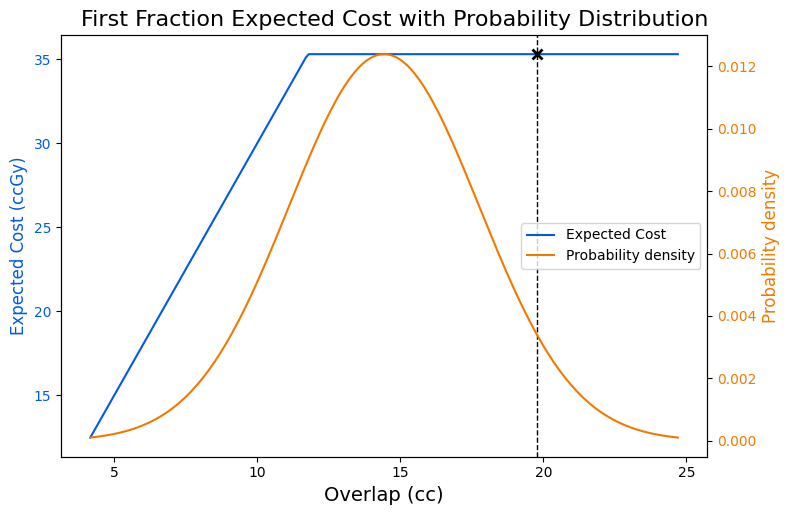

In [80]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, values_actual_frac*-1, color=COLORS['blue'], label='Expected Cost')
ax1.set_xlabel('Overlap (cc)', fontsize = 14)
ax1.set_ylabel('Expected Cost (ccGy)', color=COLORS['blue'], fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at 19.79
ax1.axvline(x=19.79, color='k', linestyle='--', linewidth=1)

closest_index = (np.abs(volume_space - 19.79)).argmin()
# Add black cross at (19.79, values_actual_frac[closest_index])
ax1.plot(19.79, values_actual_frac[closest_index]*-1, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='center right')

fig.tight_layout()
fig.suptitle('First Fraction Expected Cost with Probability Distribution', fontsize=16, y=1.02)
plt.show()


### Second Fraction

In [81]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 2, volumes = overlaps_3[:3],accumulated_dose =  6, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 6.6, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

In [82]:
values_smoothed = values_actual_frac.copy()
values_smoothed[values_smoothed < -1000] = 123412341234
values_smoothed[values_smoothed == 123412341234] = values_smoothed.min()-0.5


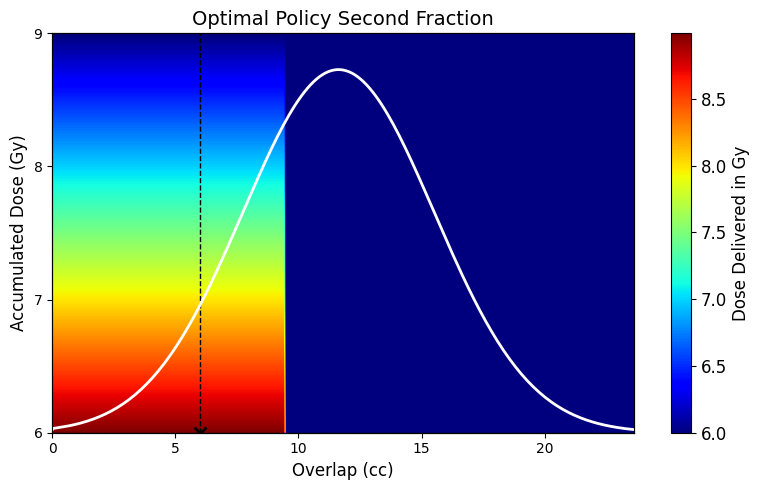

In [83]:
fig, ax1 = plt.subplots(figsize=(8, 5))
upper_limit = np.where(dose_space_adapted.round(2) == 9.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([6, 7, 8, 9])
ax1.set_title('Optimal Policy Second Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=6.01, color='k', linestyle='--', linewidth=1)
ax1.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(6.01, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

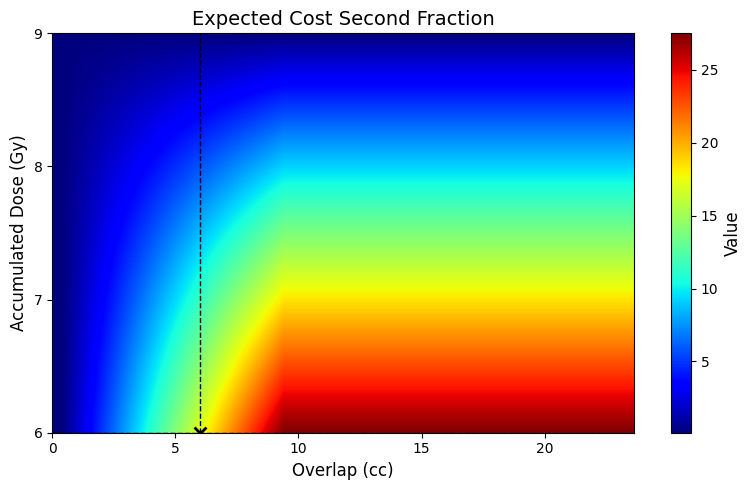

In [84]:
fig, ax1 = plt.subplots(figsize=(8, 5))


im = ax1.imshow(
    values_smoothed[:upper_limit] *-1,
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)

# Overlay grey for y > 9
# ymin, ymax = 9, dose_space_adapted[8]
# ax1.axhspan(ymin, ymax, color='white', alpha=1, zorder=2)

ax1.set_xlabel('Overlap (cc)', fontsize = 12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize = 12)
ax1.set_yticks([6, 7, 8, 9])
ax1.set_title('Expected Cost Second Fraction', fontsize=14)
fig.colorbar(im, ax=ax1).set_label('Value', fontsize=12)

# Add vertical and horizontal lines
plt.axvline(x=6.01, color='k', linestyle='--', linewidth=1)
plt.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(6.01, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

fig.tight_layout()
plt.show()

### Third Fraction

In [85]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 3, volumes = overlaps_3[:4],accumulated_dose =  15, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 6.6, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

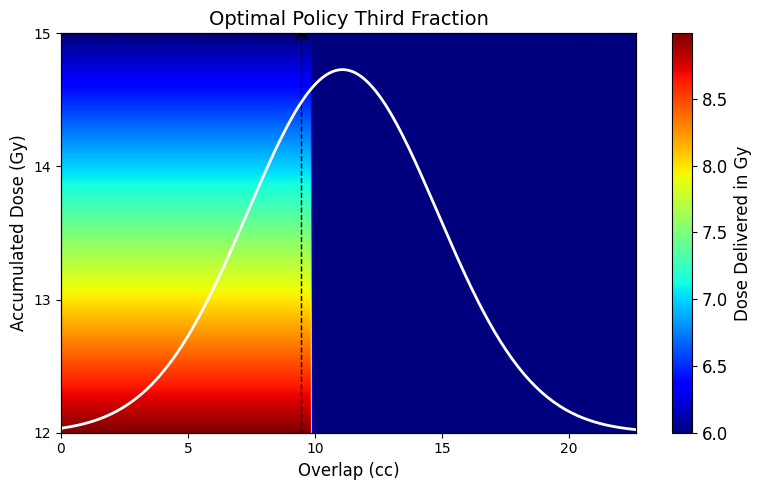

In [86]:
fig, ax1 = plt.subplots(figsize=(8, 5))
upper_limit = np.where(dose_space_adapted.round(2) == 15.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([12, 13, 14, 15])
ax1.set_title('Optimal Policy Third Fraction', fontsize=14)

# Add vertical and horizontal lines
plt.axvline(x=9.45, color='k', linestyle='--', linewidth=1)
plt.axhline(y=15, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(9.45, 15, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

### Fourth Fraction

In [87]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 4, volumes = overlaps_3[:5],accumulated_dose =  21, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 6.6, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

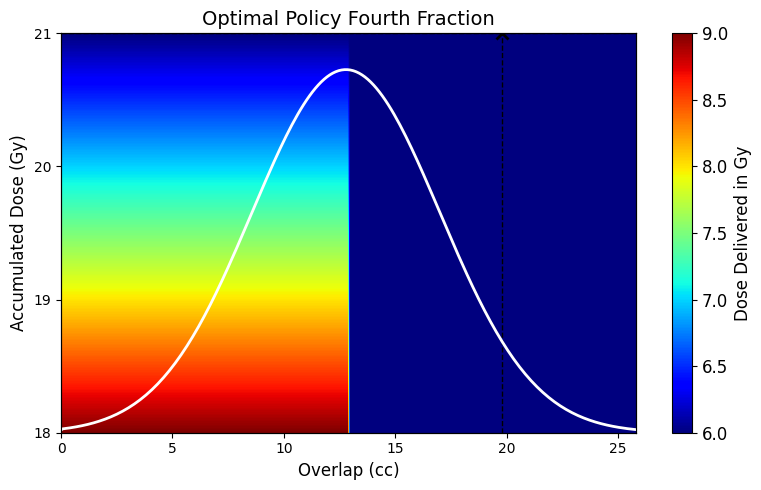

In [88]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 21.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[ upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([18,19, 20, 21])
ax1.set_title('Optimal Policy Fourth Fraction', fontsize=14)

# Add vertical and horizontal lines
plt.axvline(x=19.79, color='k', linestyle='--', linewidth=1)
plt.axhline(y=21, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(19.79, 21, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

## Fifth Fraction

In [89]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 5, volumes = overlaps_3,accumulated_dose =  27, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 6.6, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

In [90]:
from adaptive_fractionation_overlap.helper_functions import std_calc, get_state_space, probdist
from scipy.stats import norm
std = std_calc(overlaps_3[:6], alpha, beta)
distribution = norm(loc = overlaps_3[:6].mean(), scale = std)
volume_space = get_state_space(distribution)
probabilities = probdist(distribution,volume_space) #produce probabilities of the respective volumes
volume_space = volume_space.clip(0) #clip the volume space to 0cc as negative volumes do not exist

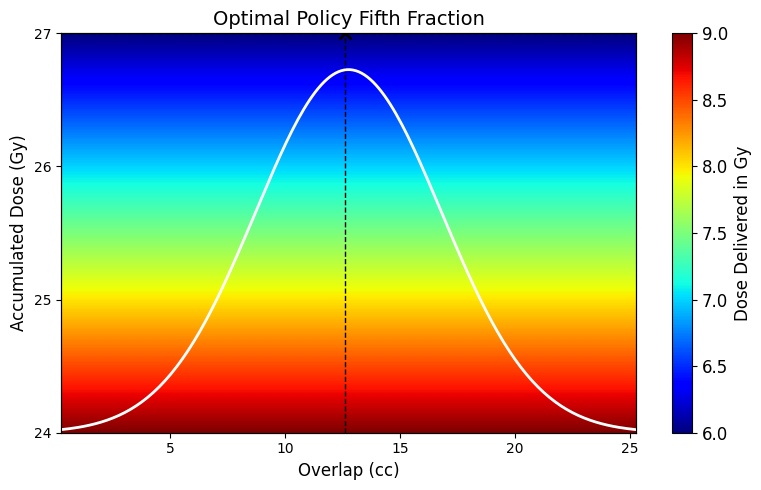

In [91]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 27.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([24,25, 26, 27,28])
ax1.set_title('Optimal Policy Fifth Fraction', fontsize=14)

# Add vertical and horizontal lines
plt.axvline(x=12.62, color='k', linestyle='--', linewidth=1)
plt.axhline(y=27, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(12.62, 27, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)

# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

## Patient 49

In [92]:
afx.adaptfx_full(overlaps_49,5, 6, 10, 8 ,0.01, alpha, beta )

(array([ 6., 10., 10.,  8.,  6.]), array([ 0.,  6., 16., 26., 34.]), -36.96)

In [93]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 1, volumes = overlaps_49[:2],accumulated_dose =  0, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 8, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

In [94]:
dose_space_adapted[8]

0.08

In [95]:
overlaps_49

array([4.27, 5.91, 3.28, 3.87, 4.18, 8.36])

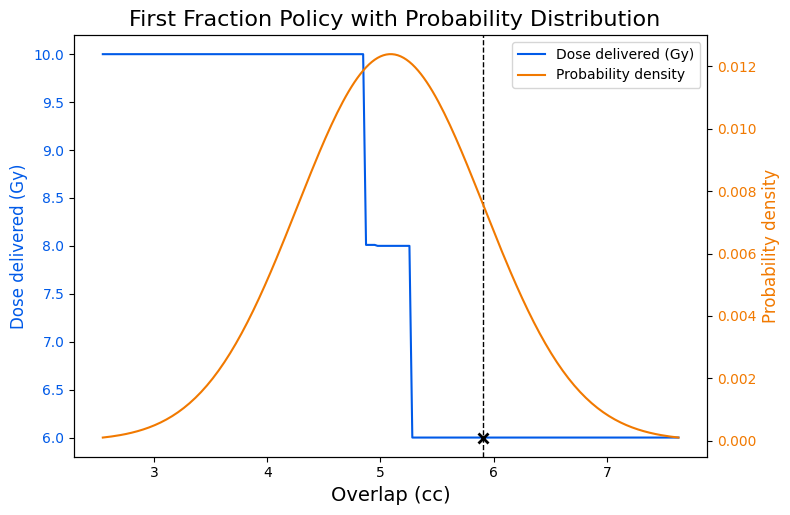

In [96]:
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, policies_overlap, color=COLORS['blue'], label='Dose delivered (Gy)')
ax1.set_xlabel('Overlap (cc)',fontsize = 14)
ax1.set_ylabel('Dose delivered (Gy)', color=COLORS['blue'],fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at overlaps_49[1]
ax1.axvline(x=overlaps_49[1], color='k', linestyle='--', linewidth=1)

# Add black cross at (overlaps_49[1], physical_dose)
ax1.plot(overlaps_49[1], physical_dose, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
fig.suptitle('First Fraction Policy with Probability Distribution', fontsize=16, y=1.02)
plt.show()


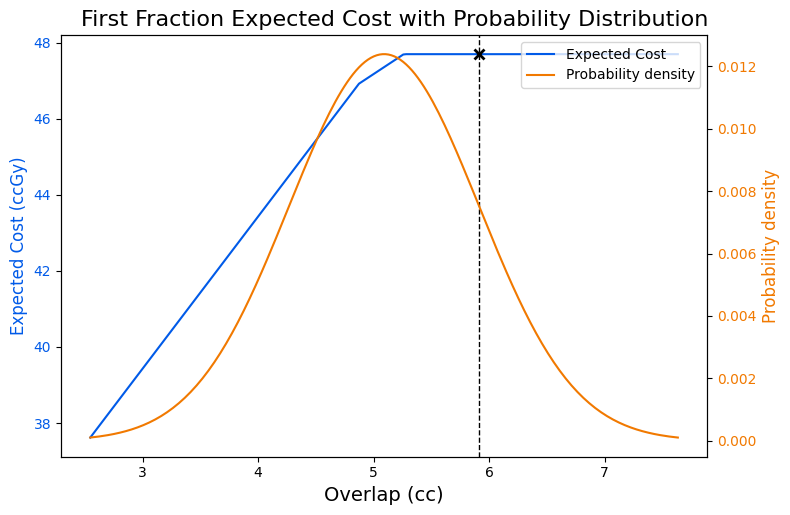

In [97]:
closest_index = np.abs((volume_space - overlaps_49[1])).argmin()
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot policies_overlap (dose delivered) on left y-axis
line1, = ax1.plot(volume_space, values_actual_frac *-1, color=COLORS['blue'], label='Expected Cost')
ax1.set_xlabel('Overlap (cc)', fontsize = 14)
ax1.set_ylabel('Expected Cost (ccGy)', color=COLORS['blue'], fontsize = 12)
ax1.tick_params(axis='y', labelcolor=COLORS['blue'])

# Add vertical line at overlaps_49[1]
ax1.axvline(x=overlaps_49[1], color='k', linestyle='--', linewidth=1)

# Add black cross at (overlaps_49[1], values_actual_frac[closest_index])
ax1.plot(overlaps_49[1], values_actual_frac[closest_index] *-1, marker='x', color='k', markersize=7, markeredgewidth=2)

# Create a second y-axis for probability density
ax2 = ax1.twinx()
line2, = ax2.plot(volume_space, probabilities, color=COLORS['orange'], label='Probability density')
ax2.set_ylabel('Probability density', color=COLORS['orange'], fontsize = 12)
ax2.tick_params(axis='y', labelcolor=COLORS['orange'])

# Combine legends from both axes
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

fig.tight_layout()
fig.suptitle('First Fraction Expected Cost with Probability Distribution', fontsize=16, y=1.02)
plt.show()


fraction 2

In [98]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 2, volumes = overlaps_49[:3],accumulated_dose =  6, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 8, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

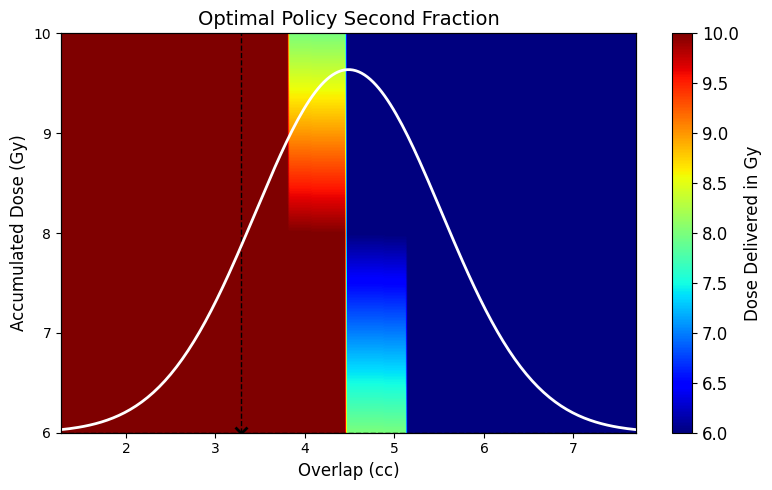

In [99]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 10.00)[0][0]

im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([6, 7, 8, 9, 10])
ax1.set_title('Optimal Policy Second Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[2], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[2], 6, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

In [100]:
values_smoothed = values_actual_frac.copy()
values_smoothed[values_smoothed < -1000] = 123412341234
values_smoothed[values_smoothed == 123412341234] = values_smoothed.min()-0.5

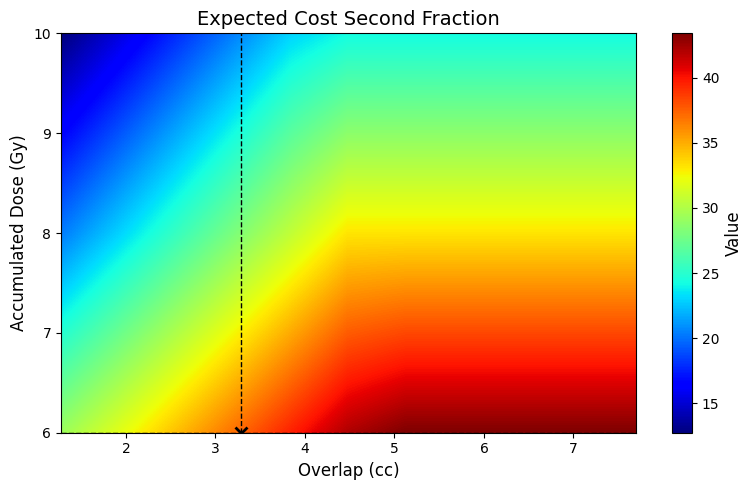

In [101]:
fig, ax1 = plt.subplots(figsize=(8, 5))


im = ax1.imshow(
    values_smoothed[:upper_limit+1] *-1,
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)

ax1.set_yticks([6, 7, 8, 9, 10])

ax1.set_xlabel('Overlap (cc)', fontsize = 12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize = 12)
ax1.set_title('Expected Cost Second Fraction', fontsize=14)
fig.colorbar(im, ax=ax1).set_label('Value', fontsize=12)

# Add vertical and horizontal lines
plt.axvline(x=3.28, color='k', linestyle='--', linewidth=1)
plt.axhline(y=6, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
plt.plot(3.28, 6, marker='x', color='k', markersize=8, markeredgewidth=2)

fig.tight_layout()
plt.show()

### Third Fraction

In [102]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 3, volumes = overlaps_49[:4],accumulated_dose =  16, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 8, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

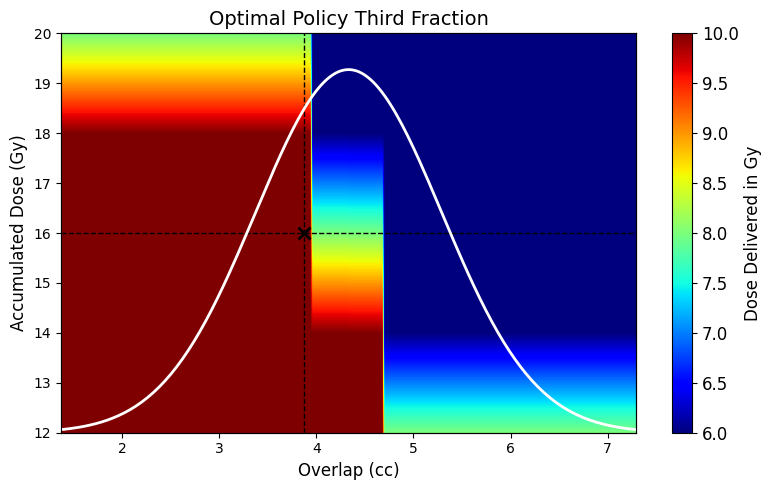

In [103]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 20.00)[0][0]
im = ax1.imshow(
    policies_overlap[:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[0], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([12, 13, 14, 15, 16, 17, 18, 19, 20])
ax1.set_title('Optimal Policy Third Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[3], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=16, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[3], 16, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

### Fourth Fraction

In [104]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 4, volumes = overlaps_49[:5],accumulated_dose =  26, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 8, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

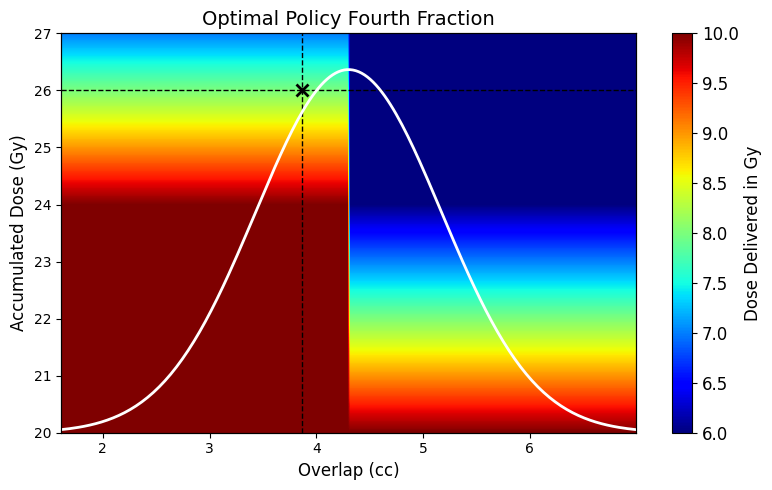

In [105]:
fig, ax1 = plt.subplots(figsize=(8, 5))

upper_limit = np.where(dose_space_adapted.round(2) == 27.00)[0][0]
lower_limit = np.where(dose_space_adapted.round(2) == 20.00)[0][0]
im = ax1.imshow(
    policies_overlap[lower_limit:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[lower_limit], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([20, 21, 22, 23, 24, 25, 26, 27, 28])
ax1.set_title('Optimal Policy Fourth Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[3], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=26, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[3], 26, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

### Fifth Fraction

In [106]:
policies, policies_overlap, volume_space, physical_dose, penalty_added, values, dose_space, probabilities, final_penalty, values_actual_frac, dose_space_adapted = afx.adaptive_fractionation_core(fraction = 5, volumes = overlaps_49,accumulated_dose =  34, number_of_fractions = 5, min_dose = 6, max_dose = 10, mean_dose = 8, dose_steps = 0.01, alpha = alpha, beta = beta, minimum_benefit = 0 )

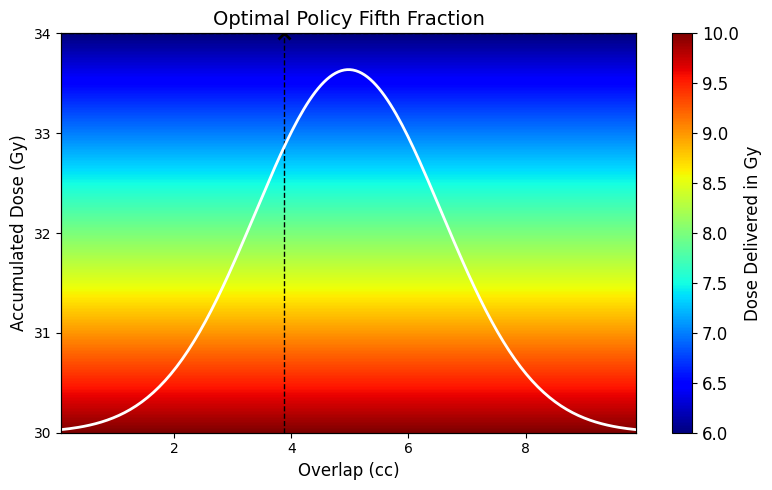

In [107]:
fig, ax1 = plt.subplots(figsize=(8, 5))
lower_limit = np.where(dose_space_adapted.round(2) == 30.00)[0][0]
upper_limit = np.where(dose_space_adapted.round(2) == 34.00)[0][0]
im = ax1.imshow(
    policies_overlap[lower_limit:upper_limit+1],
    cmap='jet',
    aspect='auto',
    extent=[volume_space[0], volume_space[-1], dose_space_adapted[lower_limit], dose_space_adapted[upper_limit]],
    origin='lower'
)
ax1.set_xlabel('Overlap (cc)', fontsize=12)
ax1.set_ylabel('Accumulated Dose (Gy)', fontsize=12)
ax1.set_yticks([30, 31, 32, 33, 34])
ax1.set_title('Optimal Policy Fifth Fraction', fontsize=14)

# Add vertical and horizontal lines
ax1.axvline(x=overlaps_49[3], color='k', linestyle='--', linewidth=1)
ax1.axhline(y=34, color='k', linestyle='--', linewidth=1)

# Add cross at intersection
ax1.plot(overlaps_49[3], 34, marker='x', color='k', markersize=8, markeredgewidth=2)

# Add colorbar to the figure, referencing the image
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('Dose Delivered in Gy', fontsize=12)
cbar.ax.tick_params(labelsize=12)


# Overlay the normal distribution in white using a twin axis
ax2 = ax1.twinx()
ax2.plot(volume_space, probabilities, color='white', linewidth=2, label='Probability Distribution')
ax2.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
ax2.set_ylim(0, probabilities.max() * 1.1)  # Adjust y-limits to fit the PDF

plt.tight_layout()
plt.show()

## Full Analysis

In this part we analyze the AF plans for all patients in the cohort

In [108]:
import adaptive_fractionation_overlap as afx

phys_doses = []
accum_doses = []
total_penalties = []
for index, patient_overlaps in enumerate(overlap_array):
    physical_doses, accumulated_doses, total_penalty = afx.adaptfx_full(patient_overlaps, number_of_fractions=5, min_dose = 6, max_dose = 10, mean_dose = prescription_doses[index]/5, dose_steps = 0.25, alpha = alpha, beta = beta)
    phys_doses.append(physical_doses)
    accum_doses.append(accumulated_doses)
    total_penalties.append(total_penalty)

In [109]:
standard_penalties  = []
for index, patient_overlaps in enumerate(overlap_array):
    d_mean = prescription_doses[index] / 5
    standard_penalty = -(patient_overlaps[1:] * (d_mean - 6)).sum()
    standard_penalties.append(standard_penalty)
benefits = np.array(total_penalties) - np.array(standard_penalties)

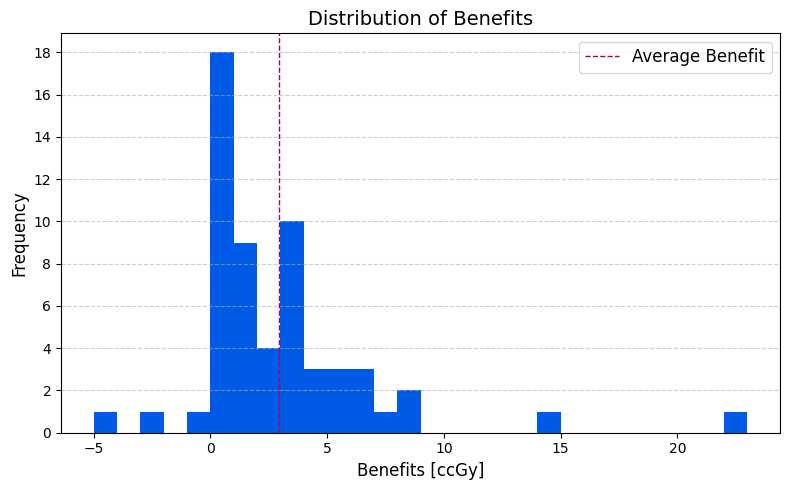

In [110]:
plt.figure(figsize=(8, 5))
bins = np.arange(-5, 24, 1)
plt.hist(benefits, bins=bins, color=COLORS['blue'])
plt.xlabel('Benefits [ccGy]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Benefits', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.yticks(np.arange(0, 19, 2))
plt.axvline(x=np.mean(benefits), color=COLORS['red'], linestyle='--', linewidth=1, label='Average Benefit')
plt.legend(fontsize = 12)
plt.tight_layout()
plt.show()

create a df with all results

In [111]:
df = pd.DataFrame({
    'Patient number': dataset['P_NUMBER'].unique(),
    'Overlaps': overlap_array.tolist(),
    'Prescription': prescription_doses,
    'AF doses': phys_doses,
    'benefits': benefits,
    'penalties': total_penalties
})
df

,Patient number,Overlaps,Prescription,AF doses,benefits,penalties
0,1.0,"[2.02, 2.41, 3.04, 1.96, 5.3, 3.27]",33.0,"[6.0, 6.0, 9.0, 6.0, 6.0]",3.708,-5.88
1,2.0,"[6.19, 10.97, 4.91, 7.65, 5.73, 5.87]",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",6.348,-14.73
2,3.0,"[9.08, 19.79, 6.02, 9.45, 19.59, 12.62]",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",22.422,-18.06
3,4.0,"[15.07, 19.81, 16.12, 22.630000000000003, 18.0...",33.0,"[6.0, 6.0, 6.0, 9.0, 6.0]",0.984,-54.27
4,5.0,"[17.150000000000002, 18.68, 18.35, 28.56000000...",33.0,"[6.0, 6.0, 6.0, 6.0, 9.0]",-2.976,-68.94
5,6.0,"[0.25, 0.53, 0.99, 2.66, 2.41, 0.27]",35.0,"[6.0, 6.0, 6.0, 7.0, 10.0]",3.370,-3.49
6,7.0,"[5.41, 8.2, 9.16, 8.18, 5.45, 7.28]",40.0,"[6.0, 6.0, 10.0, 10.0, 8.0]",7.460,-69.08
7,8.0,"[0.41, 2.37, 0.68, 2.67, 1.62, 1.27]",40.0,"[6.0, 10.0, 6.0, 8.0, 10.0]",6.180,-11.04
8,9.0,"[9.52, 12.18, 8.52, 9.39, 9.639999999999999, 8...",33.0,"[6.0, 9.0, 6.0, 6.0, 6.0]",3.570,-25.56
9,10.0,"[4.58, 5.78, 6.3, 3.83, 4.67, 2.69]",33.0,"[6.0, 6.0, 9.0, 6.0, 6.0]",2.472,-11.49


extend results with the upper bound treatment which are produced by computing the optimal plan for each patient assuming full knowledge of the overlap volumes

In [112]:
import scipy.optimize as opt
# upper bound code
def calc_upper_bound_treatment(overlaps, prescription_dose, number_of_fractions, min_dose = 6, max_dose = 10):
    """
    Calculate the upper bound treatment for a given overlap and prescription dose.

    Parameters
    ----------
    overlaps : array
        The overlaps for the patient.
    prescription_dose : float
        The prescription dose for the patient.
    number_of_fractions : int
        The number of fractions in the treatment.

    Returns
    -------
    float
        The upper bound treatment value.
    """
    # Objective: minimize sum((dose_i - min_dose) * overlaps_i)
    def penalty(doses):
        return np.sum((doses - min_dose) * overlaps[1:])  # skip planning scan

    # Constraints: sum(doses) == prescription_dose, min_dose <= doses <= max_dose
    cons = ({
        'type': 'eq',
        'fun': lambda doses: np.sum(doses) - prescription_dose
    })
    bounds = [(min_dose, max_dose)] * number_of_fractions

    # Initial guess: equal split
    x0 = np.full(number_of_fractions, prescription_dose / number_of_fractions)

    res = opt.minimize(penalty, x0, bounds=bounds, constraints=cons)
    if res.success:
        # Calculate the minimized penalty value
        total_penalty = penalty(res.x)
        return res.x, total_penalty
    else:
        return None, None

# Calculate upper bounds for all patients and store in a DataFrame
upper_bound_doses = []
upper_bound_penalties = []

for overlaps, prescription, n_fractions in zip(overlap_array, prescription_doses, [5]*len(overlap_array)):
    doses, penalty = calc_upper_bound_treatment(overlaps, prescription, n_fractions)
    upper_bound_doses.append(np.round(doses))
    upper_bound_penalties.append(penalty)
upper_bound_benefits = -np.array(upper_bound_penalties) - np.array(standard_penalties)
df_upper_bounds = pd.DataFrame({
    'Patient number': dataset['P_NUMBER'].unique(),
    'Upper Bound Doses': upper_bound_doses,
    'Upper Bound Benefits': upper_bound_benefits
})

df_upper_bounds
df_complete = pd.concat([df, df_upper_bounds[['Upper Bound Doses', 'Upper Bound Benefits']]], axis=1)

In [113]:
# Build the new table
rows = []
for idx, row in df_complete.iterrows():
    patient_number = row['Patient number']
    overlaps = row['Overlaps']  # 6 entries: [Planning, F1, F2, F3, F4, F5]
    af_doses = row['AF doses']  # 5 entries: [F1, F2, F3, F4, F5]
    upper_bound_doses = row['Upper Bound Doses']  # 5 entries: [F1, F2, F3, F4, F5]
    upper_bound_benefits = row['Upper Bound Benefits']
    benefits = row['benefits']

    # Overlap row
    rows.append({
        'Patient number': patient_number,
        'Plan type': 'Overlap',
        'Planning scan': overlaps[0],
        'Fraction 1': overlaps[1],
        'Fraction 2': overlaps[2],
        'Fraction 3': overlaps[3],
        'Fraction 4': overlaps[4],
        'Fraction 5': overlaps[5],
        'benefits': np.nan
    })
    # AF row
    rows.append({
        'Patient number': patient_number,
        'Plan type': 'AF',
        'Planning scan': np.nan,
        'Fraction 1': af_doses[0],
        'Fraction 2': af_doses[1],
        'Fraction 3': af_doses[2],
        'Fraction 4': af_doses[3],
        'Fraction 5': af_doses[4],
        'benefits': benefits
    })
    # Upper Bound row (copy of AF for now)
    rows.append({
        'Patient number': patient_number,
        'Plan type': 'Upper Bound',
        'Planning scan': np.nan,
        'Fraction 1': upper_bound_doses[0],
        'Fraction 2': upper_bound_doses[1],
        'Fraction 3': upper_bound_doses[2],
        'Fraction 4': upper_bound_doses[3],
        'Fraction 5': upper_bound_doses[4],
        'benefits': upper_bound_benefits
    })

# Create the new DataFrame
df_long = pd.DataFrame(rows)
df_long = df_long[['Patient number', 'Plan type', 'Planning scan', 'Fraction 1', 'Fraction 2', 'Fraction 3', 'Fraction 4', 'Fraction 5', 'benefits']]

df_long.replace({np.nan: ''}, inplace=True)
# df_long.to_excel('ACTION_patients_overlap_adaptfx_long.xlsx', index=False)

Plot histogram of the differences between adaptive fractionation and the upper bound

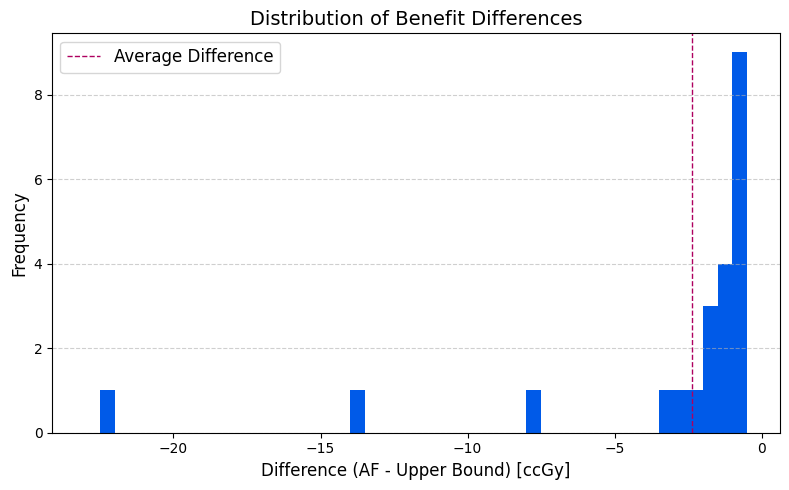

In [114]:
indexes_equal = np.round(df_complete['benefits'],2) == np.round(df_complete['Upper Bound Benefits'],2)
plt.figure(figsize=(8, 5))
bins = np.arange(-23, 0, 0.5) 
plt.hist(df_complete.loc[~indexes_equal]['benefits'] - df_complete.loc[~indexes_equal]['Upper Bound Benefits'], bins=bins, color=COLORS['blue'])
# plt.hist(df_complete.loc[~indexes_equal]['benefits'] - df_complete.loc[~indexes_equal]['Upper Bound Benefits'], bins=50, color=COLORS['blue'])
plt.xlabel('Difference (AF - Upper Bound) [ccGy]', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Benefit Differences', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.axvline(x=np.mean(df_complete.loc[~indexes_equal]['benefits'] - df_complete.loc[~indexes_equal]['Upper Bound Benefits']), color=COLORS['red'], linestyle='--', linewidth=1, label='Average Difference')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()